# Deblurring Dataset

## Prerequisite
We need to blur image first

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import os
import random
from tqdm import tqdm

Read image

In [120]:
origin_paths = []

for file in sorted(os.listdir('Immunofluorescence images')):
    if file != '.DS_Store':
        if file != 'File name_IF images.docx':
            origin_paths.append('Immunofluorescence images/' + file)

print(origin_paths[0:5])

['Immunofluorescence images/1H_Nrf2_No_ADT_1_DAPI.tif', 'Immunofluorescence images/1H_Nrf2_No_ADT_1_FITC.tif', 'Immunofluorescence images/1H_Nrf2_No_ADT_1_merged.tif', 'Immunofluorescence images/1H_Nrf2_No_ADT_2_DAPI.tif', 'Immunofluorescence images/1H_Nrf2_No_ADT_2_FITC.tif']


In [121]:
origin_paths[405][26:-4]

'1H_Nrf2_UV_AP39_3_5_FITC'

Average Blur & Gaussian Blur preview

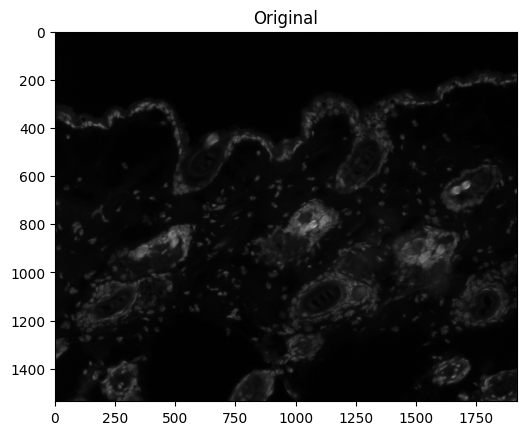

In [122]:
img = cv2.imread(origin_paths[0], 0)
plot = plt.imshow(img, cmap='gray')
plt.title('Original')
plt.show()

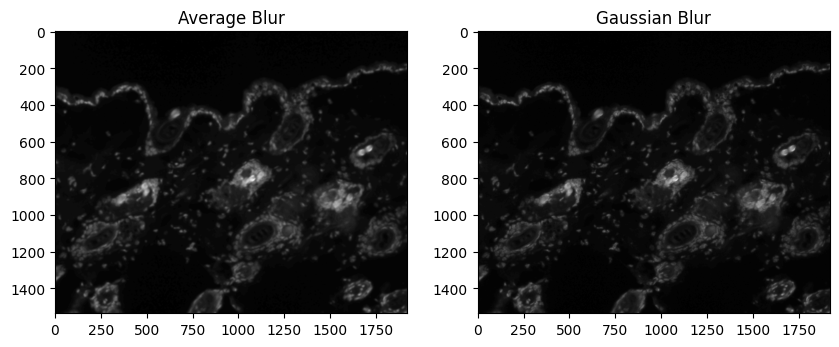

In [123]:
# Average blur
avg_blur = cv2.blur(img, (9,9))
gss_blur = cv2.GaussianBlur(img, (9,9), 0)

fig = plt.figure(10, (10,10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(avg_blur, cmap='gray')
ax.set_title('Average Blur')
ax = fig.add_subplot(1, 2, 2)
ax.imshow(gss_blur, cmap='gray')
ax.set_title('Gaussian Blur')
plt.show()

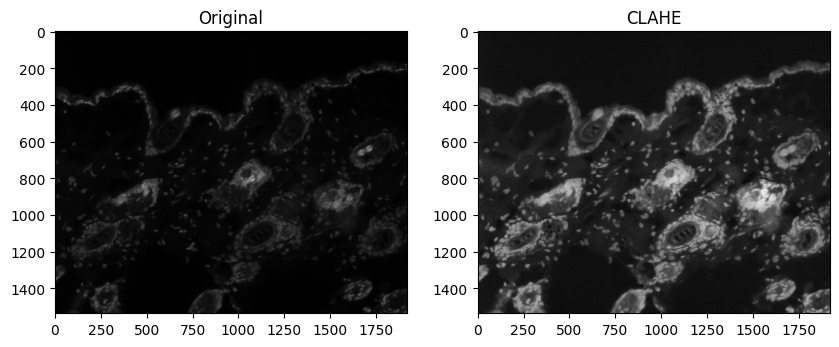

In [125]:
clahe = cv2.createCLAHE(clipLimit=8.0, tileGridSize=(8,8)).apply(img)

fig = plt.figure(10, (10,10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(img, cmap='gray')
ax.set_title('Original')
ax = fig.add_subplot(1, 2, 2)
ax.imshow(clahe, cmap='gray')
ax.set_title('CLAHE')
plt.show()

Create blur dataset

In [126]:
for path in tqdm(origin_paths):
    img = cv2.imread(path, 0)
    avg_blur = cv2.blur(img, (5,5))
    gss_blur = cv2.GaussianBlur(img, (5,5), 0)

    img_name = path[26:-4]
    avg_path = 'Blur images/Average Blur/' + img_name + '_avg_blur.png'
    gss_path = 'Blur images/Gaussian Blur/' + img_name + '_gss_blur.png'
    
    cv2.imwrite(avg_path, avg_blur)
    cv2.imwrite(gss_path, gss_blur)

100%|██████████| 590/590 [00:31<00:00, 19.03it/s]


Create CLAHE dataset

In [127]:
for path in tqdm(origin_paths):
    img = cv2.imread(path, 0)
    clahe = cv2.createCLAHE(clipLimit=8.0, tileGridSize=(8,8)).apply(img)
    
    img_name = path[26:-4]
    clahe_path = 'Blur images/CLAHE/' + img_name + '_clahe.png'
    
    cv2.imwrite(clahe_path, clahe)

100%|██████████| 590/590 [00:27<00:00, 21.38it/s]


## 1. CNN

### Prepare image

In [1]:
gssblur_paths = []
for file in sorted(os.listdir('Blur images/Gaussian Blur')):
    if file != '.DS_Store':
        gssblur_paths.append('Blur images/Gaussian Blur/' + file)

clahe_paths = []
for file in sorted(os.listdir('Blur images/CLAHE')):
    if file != '.DS_Store':
        clahe_paths.append('Blur images/CLAHE/' + file)

print(len(clahe_paths))
print(len(gssblur_paths))

590
590


### Preprocessing

Convert image to 224x224 and change to array float32/255

In [5]:
import tensorflow as tf
from tqdm import tqdm

clean_frame = []
for path in tqdm(clahe_paths):
    img = tf.keras.preprocessing.image.load_img(path, color_mode='grayscale', target_size=(256, 256))
    img = tf.keras.preprocessing.image.img_to_array(img).astype('float32')/255
    clean_frame.append(img)

clean_frame = np.array(clean_frame)

blur_frame = []
for path in tqdm(gssblur_paths):
    img = tf.keras.preprocessing.image.load_img(path, color_mode='grayscale', target_size=(256, 256))
    img = tf.keras.preprocessing.image.img_to_array(img).astype('float32')/255
    blur_frame.append(img)

blur_frame = np.array(blur_frame)

print(clean_frame.shape)
print(blur_frame.shape)

100%|██████████| 590/590 [00:17<00:00, 33.91it/s]

(590, 256, 256, 1)
(590, 256, 256, 1)


Split train test

In [6]:
from sklearn.model_selection import train_test_split

x = clean_frame
y = blur_frame
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(x_train[0].shape)
print(y_train[0].shape)

(256, 256, 1)
(256, 256, 1)


70


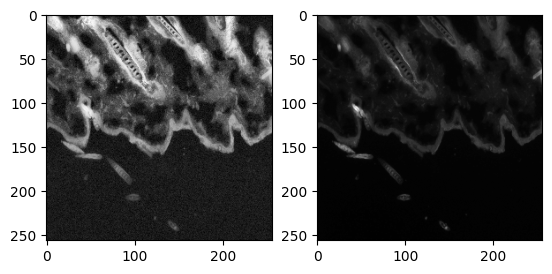

In [7]:
r = random.randint(0, len(clean_frame)-1)
print(r)
fig = plt.figure()
fig.subplots_adjust(hspace=0.1, wspace=0.2)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(clean_frame[r], cmap='gray')
ax = fig.add_subplot(1, 2, 2)
ax.imshow(blur_frame[r], cmap='gray')

### Generate Network

In [8]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.utils.vis_utils import plot_model
from keras import backend as K

seed = 21
random.seed = seed
np.random.seed = seed

In [16]:
# Network Parameters
input_shape = (256, 256, 1)
batch_size = 16
kernel_size = 3
latent_dim = 256

# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [64, 128, 256]

#### Building Encoder

We will directly use the libraries in order to avoid the cumbersome hand computations. We will be building a stack of `Conv2D(64) - Conv2D(128) - Conv2D(256)`. The model is going to be having input shape `(512, 512, 1)` and kernel size equal to `3` and the Encoder will compress this shape to `(16, 16, 256)` and will further flatten this into a one dimensional array which will be the input for our Decoder.

In [17]:
inputs = Input(shape = input_shape, name = 'encoder_input')
x = inputs

`K.int_shape()` here helps in converting a tensor into a tuple of integers. Instantiating the encoder model,

In [18]:
for filters in layer_filters:
    x = Conv2D(
        filters=filters, kernel_size=kernel_size, strides=2, 
        activation='relu', padding='same'
        )(x)
shape = K.int_shape(x)
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

In [19]:
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      640       
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 256)       295168    
                                                                 
 flatten_1 (Flatten)         (None, 262144)            0         
                                                                 
 latent_vector (Dense)       (None, 256)               67109120  
                                                                 
Total params: 67,478,784
Trainable params: 67,478,784
Non-t

#### Building Decoder

Decoder model will be similar to the encoder model but it will be doing the reverse or opposite computations. We will first manually convert the one dimensional array from the encoder model to the shape `(16, 16, 256)` and then send it to the decoder to decode it back to `(512, 521, 1)` shape. So the stack here will be `Conv2DTranspose(256) - Conv2DTranspose(128) - Conv2DTranspose(64)`.

In [20]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(
        filters=filters, kernel_size=kernel_size, strides=2,
        activation='relu', padding='same'
        )(x)

outputs = Conv2DTranspose(
    filters=3, kernel_size=kernel_size, activation='sigmoid', 
    padding='same', name='decoder_output'
    )(x)

In [21]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 256)]             0         
                                                                 
 dense_1 (Dense)             (None, 262144)            67371008  
                                                                 
 reshape_1 (Reshape)         (None, 32, 32, 256)       0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 64, 64, 256)      590080    
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 128, 128, 128)    295040    
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 256, 256, 64)     7379

#### Building the Autoencoder Model
Now that we have our encoder and decoder models, we can combine them to finally build our Autoencoder Model.
```
Autoencoder Model = Encoder Model + Decoder Model
```
Instantiating the Autoencoder model,

In [22]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 256, 256, 1)]     0         
                                                                 
 encoder (Functional)        (None, 256)               67478784  
                                                                 
 decoder (Functional)        (None, 256, 256, 3)       68331651  
                                                                 
Total params: 135,810,435
Trainable params: 135,810,435
Non-trainable params: 0
_________________________________________________________________


**Last but not the least** </br>
Before training our model, there’s one last thing we need to do, choose the hyperparameters. I am choosing Loss function to be Mean Squared Error, Optimizer to be Adam, and evaluation metric to be Accuracy.
Now defining the learning rate reducer to reduce the learning rate if there’s no improvement in the metric,

In [24]:
autoencoder.compile(loss='mse', optimizer='adam',metrics=["acc"])

In [25]:
lr_reducer = ReduceLROnPlateau(
    factor=np.sqrt(0.1), cooldown=0, patience=5,
    verbose=1,min_lr=0.5e-6
    )

callbacks = [lr_reducer]

### Training the model

In [26]:
history = autoencoder.fit(
    blur_frame, clean_frame, validation_data=(blur_frame, clean_frame),
    epochs=100, batch_size=batch_size, callbacks=callbacks
    )

Epoch 1/100


2022-11-11 22:32:05.185660: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-11 22:32:05.886237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - ETA: 0s - loss: 0.0710 - acc: 5.1466e-06

2022-11-11 22:32:35.348423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 43s 1s/step - loss: 0.0710 - acc: 5.1466e-06 - val_loss: 0.0320 - val_acc: 2.8966e-06 - lr: 0.0010
Epoch 2/100
37/37 [==============================] - 42s 1s/step - loss: 0.0301 - acc: 3.8794e-06 - val_loss: 0.0291 - val_acc: 3.1293e-06 - lr: 0.0010
Epoch 3/100
37/37 [==============================] - 50s 1s/step - loss: 0.0287 - acc: 3.9828e-06 - val_loss: 0.0280 - val_acc: 3.7500e-06 - lr: 0.0010
Epoch 4/100
37/37 [==============================] - 70s 2s/step - loss: 0.0280 - acc: 3.4138e-06 - val_loss: 0.0274 - val_acc: 3.5173e-06 - lr: 0.0010
Epoch 5/100
37/37 [==============================] - 67s 2s/step - loss: 0.0272 - acc: 3.6983e-06 - val_loss: 0.0264 - val_acc: 3.4656e-06 - lr: 0.0010
Epoch 6/100
37/37 [==============================] - 65s 2s/step - loss: 0.0260 - acc: 3.3362e-06 - val_loss: 0.0242 - val_acc: 3.9311e-06 - lr: 0.0010
Epoch 7/100
37/37 [==============================] - 66s 2s/step - loss: 0.0236 - acc: 3.5173e-06 - 

KeyboardInterrupt: 

In [27]:
plt.figure(figsize=(12,8))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Train', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0, 101, 25))
plt.show()

NameError: name 'history' is not defined

<Figure size 1200x800 with 0 Axes>

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(0, 101, 25))
plt.show()

In [ ]:
for i in range(3):
    
    r = random.randint(0, len(clean_frame)-1)

    x, y = blur_frame[r],clean_frame[r]
    x_inp=x.reshape(1,128,128,3)
    result = autoencoder.predict(x_inp)
    result = result.reshape(128,128,3)

    fig = plt.figure(figsize=(12,10))
    fig.subplots_adjust(hspace=0.1, wspace=0.2)

    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(x)
    ax.set_title('Input')

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(y)
    ax.set_title('Ground Truth')

    ax = fig.add_subplot(1, 3, 3)
    plt.imshow(result)
    ax.set_title('Predicted Value')